# Problem 3

In [8]:
import numpy as np
import scipy.integrate as spi
import scipy.special as sps
import matplotlib.pyplot as plt

The gamma function is defined as follows:

$$ \Gamma(x)=\int_0^{\infty}t^{x-1}e^{-t}dt,\: x>0 $$

We will compute the value of this function using a variety of approaches.

We first define the function that we are integrating, which we will do in two pieces to facillitate the use of Gauss-Laguerre later on.

In [2]:
#Computes the t^(x-1) factor
#Assumes x>0
def tx(t, x):
    return t**(x-1)

#Computes the full integrand
def func(t, x):
    return tx(t,x)*np.exp(-t)

In [5]:
x = np.array([2,4,6,8,10]) #Test locations

exact = sps.factorial(x-1) #Exact values
print(exact)

[1.0000e+00 6.0000e+00 1.2000e+02 5.0400e+03 3.6288e+05]


To analyze our approximations we will be using the following test locations: $x=2,4,6,8,10$. Given that these are all positive integers we can exploit the fact that $\Gamma(k)=(k-1)!,\:k\in\mathbb{N}$ to get exact values. These exact values can be seen printed above, which we note is the same result as the SciPy gamma function (Matlab equivalent in Python), the output of which can be see below. 

In [6]:
print(sps.gamma(x))

[1.0000e+00 6.0000e+00 1.2000e+02 5.0400e+03 3.6288e+05]


## a).

Here we want to apply the composite Trapezoidal rule, but given that we are integrating on an infinite interval we need to stop somewhere. We have two things to consider as we do this. First, we want to choose a truncation point that does not cut off too much of the area. Second, we want to approximate our truncated region well, so it can't be too big or else computational complexity will cause problems.

First we define our composite trapezoidal function.

In [22]:
'''
Function: compTrap -> Composite Trapezoidal rule
    Uses the composite Trapezoidal rule to compute an approximation
    to the integral of a function on an interval. Assumes that the
    function and interval constitute a valid integral.
Input:
    func: The callable function handle
    a: Left hand endpoint
    b: Right hand endpoint
    n: Number of subintervals greater than 0
    info: Return number of function evaluations (optional)
Output:
    I: Integral approximation
    len(x): Number of function evaluations (optional)
'''
def compTrap(func, a, b, n, info=False, args=()):
    if not callable(func) or n<=0:
        raise ValueError('Function not callable, or non-positive number of subintervals.')
        
    x = np.linspace(a, b, n+1) #Evaluation locations
    h = x[1] - x[0] #Spacing
    
    f = func(x, *args) #Evaluate the function at all locations
    f[0], f[-1] = 0.5*f[0], 0.5*f[-1] #Weight the endpoints
    
    I = h*np.sum(f)
    
    if info:
        return I, len(x)
    else:
        return I

In order to determine our interval endpoint (we always start at 0) and our step size we need to do some investigation. Depending on the value of $x$ the gamma function can look more like exponential decay, or more like some sort of weird gaussian. Lets plot our function for the two most extreme values (2 and 10).

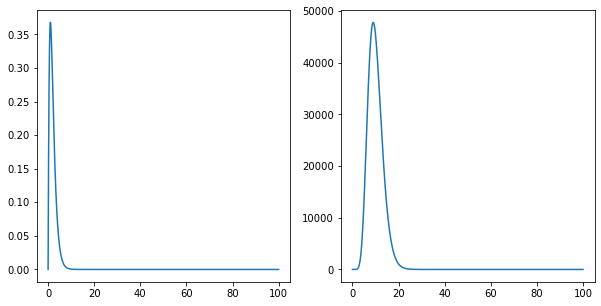

In [14]:
t = np.linspace(0,100,1000)
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(t, func(t,2))
ax[1].plot(t, func(t,10));

In [34]:
func(100,10)

3.720075976020836e-26

On the left we see a plot for $x=2$ and on the right a plot for $x=10$. We can see that it decays pretty rapidly in either case, so lets take our endpoint to be 100. The only other question is how many intervals? Lets iterate with this until we reach some kind of convergence.

In [35]:
a = 0
b = 100

In [38]:
n = 100
prev = compTrap(func, a, b, n, args=(10,))
err = np.inf
tol = 10e-12

while err > tol:
    n += 20
    cur = compTrap(func, a, b, n, args=(10,))
    err = np.abs(cur-prev)/np.abs(cur)
    
    prev = cur
    
print(n)

220


We have iterated until the relative change in approximations was less than $10^{-12}$, which gives us 220 subintervals. This means our steb size is $100/220=0.\bar{45}$.

In [40]:
m = 220

In [41]:
trap = np.zeros(len(x))

for i,xi in enumerate(x):
    trap[i] = compTrap(func, a, b, m, args=(xi,))

In [42]:
print(trap)

[9.82958789e-01 6.00033855e+00 1.19999969e+02 5.04000001e+03
 3.62880000e+05]


From a quick glance at the output above we can see that composite Trapezoidal seems to be doing okay. There is clearly some error, but it doesn't look like too much. Let's look at this more by computing the absolute error with the exact function values.

In [43]:
print('Abs. error w/ exact:\n{}\n'.format(np.abs(trap-exact)))

Abs. error w/ exact:
[1.70412106e-02 3.38548812e-04 3.13197777e-05 6.23327378e-06
 2.08575511e-06]



The largest error appears in evaluating $\Gamma(2)$ and is on the order of $10^{-2}$. This makes sense given that the peak is much sharper for smaller values of $x$.

## b).

Here we use the Python equivalent of the Matlab *quad* function (an adaptive quadrature scheme). We will apply this on the same interval we determined earlier. We will compare the accuracy, and the number of function evaluations.

In [44]:
quad = np.zeros((2,len(x)))

for i,xi in enumerate(x):
    out = spi.quad(func, 0, b, args=(xi,), full_output=1)
    quad[0,i] = out[0]
    quad[1,i] = out[2]['neval']

In [45]:
print('Function results: \n{}\n'.format(quad[0]))
print('Function evaluations: \n{}\n'.format(quad[1]))

Function results: 
[1.0000e+00 6.0000e+00 1.2000e+02 5.0400e+03 3.6288e+05]

Function evaluations: 
[147. 189. 189. 189. 189.]



We can see the results of the *quad* function above, and it appears to be doing quite well. Next, we look at the absolute error with the exact values and compare the result to that achieved using composite Trapezoidal rule.

In [46]:
print('Abs. error w/ exact:\n{}\n'.format(np.abs(quad[0]-exact)))

Abs. error w/ exact:
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 5.82076609e-11]



The only function evaluation that has any resulting error is for $\Gamma(10)$ -- on the order of $10^{-11}$. This is noticeably different than composite Trapezoidal, specifically much better. Given that we used 220 intervals in the trapezoidal rule we know we will have 221 function evaluations. This is roughly 30-80 more than the adaptive quadrature routine requires. Altogether, we see that adaptive quadrature is more accurate and more efficient although we note that it seems to be better for smaller values of x.

## c).

Here we use Gauss-Laguerre quadrature which is designed for the infinite interval $[0,\infty)$ with weighting $w(t)=e^{-t}$. We have converted the provided Matlab code into Python which we can use to obtain the weights and abscissae.

In [47]:
'''
Function: GLQuadData -> Gauss-Laguerre nodes and weights
    Finds the node locations and associated weights for nth order
    Gauss-Laguerre quadrature.
Input:
    n: Order of the quadrature rule
Output:
    x: Quadrature nodes
    w: Quadrature weights
'''
def quadGLData(n):
    J = np.diag(range(1, 2*n, 2)) -\
        np.diag(range(1, n), k=1) -\
        np.diag(range(1, n), k=-1)
        
    d, V = np.linalg.eig(J)
    ix = np.argsort(d)
    
    x = d[ix]
    w = (V[0, ix])**2
    
    return x, w

In [59]:
n = 100 #set order
t, w = quadGLData(n)

quadGL = np.zeros(len(x))

for i,xi in enumerate(x):
    quadGL[i] = np.sum(tx(t,xi)*w)

In [60]:
print(quadGL)

[1.0000e+00 6.0000e+00 1.2000e+02 5.0400e+03 3.6288e+05]


As with the other schemes we will compare our result with the exact values.

In [61]:
print('Abs. error w/ exact:\n{}\n'.format(np.abs(quadGL-exact)))

Abs. error w/ exact:
[2.17603713e-14 4.08562073e-14 2.81374923e-12 2.04636308e-10
 5.00585884e-09]



We see a suprising result here. Specifically, we cannot seem to achieve as good of accuracy as with the adaptive quadrature routine. As well, we notice that the approximations are better for smaller values of $x$ which sets it apart from trapezoidal. The approximations are still very good, but it is suprising that they are not as good as adaptive quadrature.